This project I have selected Ebay to scrapper and gather data.

--------
## Step - 1
Scrapping

In [ ]:
import csv
import re
import urllib.parse
import urllib.request
from threading import Thread

from bs4 import BeautifulSoup

data = {}
country_dict = {
    'au': '.com.au',
    'at': '.at',
    'be': '.be',
    'ca': '.ca',
    'ch': '.ch',
    'de': '.de',
    'es': '.es',
    'fr': '.fr',
    'hk': '.com.hk',
    'ie': '.ie',
    'it': '.it',
    'my': '.com.my',
    'nl': '.nl',
    'ph': '.ph',
    'pl': '.pl',
    'sg': '.com.sg',
    'uk': '.co.uk',
    'us': '.com',
}
thread_list = []
condition_dict = {
    'all': '',
    'new': '&LH_ItemCondition=1000',
    'opened': '&LH_ItemCondition=1500',
    'refurbished': '&LH_ItemCondition=2500',
    'used': '&LH_ItemCondition=3000'
}

type_dict = {
    'all': '&LH_All=1',
    'auction': '&LH_Auction=1',
    'bin': '&LH_BIN=1',
    'offers': '&LH_BO=1'
}


def items(query, country='us', condition='all', item_type='all'):
    if country not in country_dict:
        raise Exception('Country not supported, please use one of the following: ' + ', '.join(country_dict.keys()))

    if condition not in condition_dict:
        raise Exception('Condition not supported, please use one of the following: ' + ', '.join(condition_dict.keys()))

    if item_type not in type_dict:
        raise Exception('Type not supported, please use one of the following: ' + ', '.join(type_dict.keys()))

    soup = get_html(query, country, condition, item_type, already_sold=False)
    data = parse_items(soup)

    return data


def average(query, country='us', condition='all'):
    if country not in country_dict:
        raise Exception('Country not supported, please use one of the following: ' + ', '.join(country_dict.keys()))

    if condition not in condition_dict:
        raise Exception('Condition not supported, please use one of the following: ' + ', '.join(condition_dict.keys()))

    soup = get_html(query, country, condition, item_type='all', already_sold=True)
    data = parse_prices(soup)

    avg_price = round(__average(data['price_list']), 2)
    avg_shipping = round(__average(data['shipping_list']), 2)

    return {
        'price': avg_price,
        'shipping': avg_shipping,
        'total': round(avg_price + avg_shipping, 2)
    }


def get_html(query, country, condition='', item_type='all', already_sold=True):
    already_sold_string = '&LH_Complete=1&LH_Sold=1' if already_sold else ''

    # Build the URL
    parsed_query = urllib.parse.quote(query).replace('%20', '+')
    url = f'https://www.ebay{country_dict[country]}/sch/i.html?_from=R40&_nkw=' + parsed_query + already_sold_string + \
          condition_dict[condition] + type_dict[item_type]

    # Get the web page HTML
    request = urllib.request.urlopen(url)
    soup = BeautifulSoup(request.read(), 'html.parser')

    return soup


def get_info_single_product(url):
    global data
    item_code = url[url.find('itm') + 4: url.find('?')]
    request = urllib.request.urlopen(url)
    soup = BeautifulSoup(request.read(), 'html.parser')

    seller_name_element = soup.find('h2', class_='d-stores-info-categories__container__info__section__title')
    seller_name = seller_name_element.get_text(strip=True) if seller_name_element else ""

    feedback_pr_elm = soup.find('div', {'class': 'd-stores-info-categories__container__info__section__item'})
    feedback_pr = feedback_pr_elm.get_text(strip=True) if feedback_pr_elm else "0"

    labels = [elm.get_text(strip=True) if elm else "" for elm in
              soup.findAll('div', {'class': 'fdbk-detail-seller-rating__label'})]
    values = [elm.get_text(strip=True) if elm else "0.0" for elm in
              soup.findAll('span', {'class': 'fdbk-detail-seller-rating__value'})]

    item_primary_price_elm = soup.find('div', {'class': 'x-price-primary'})
    item_primary_price = item_primary_price_elm.get_text(strip=True) if item_primary_price_elm else "0"

    item_approx_price_elm = soup.find('div', {'class': 'x-price-approx'})
    item_approx_price = item_approx_price_elm.get_text(strip=True) if item_approx_price_elm else "0"

    comment_elm = soup.findAll('div', {'class': 'fdbk-container__details__comment'})
    comment = "&".join(i.get_text(strip=True) for i in comment_elm) if comment_elm else "0"

    item_data = {
        'seller_name': seller_name,
        'feedback_pr': feedback_pr,
        'item_primary_price': ".".join(re.findall(r'[0-9]+', item_primary_price)),
        'item_approx_price': ".".join(re.findall(r'[0-9]+', item_approx_price, )),
        'comment': comment,
    }
    item_data.update({i: j for i, j in zip(labels, values)})
    data.setdefault(item_code, {}).update(item_data)


def parse_items(soup):
    global data
    raw_items = soup.find_all('div', {'class': 's-item__info clearfix'})

    for item in raw_items[1:]:

        # Get item data
        title = item.find(class_="s-item__title").find('span').get_text(strip=True)

        price = parse_raw_price(item.find('span', {'class': 's-item__price'}).get_text(strip=True))

        try:
            shipping = parse_raw_price(
                item.find('span', {'class': 's-item__shipping s-item__logisticsCost'}).find('span', {
                    'class': 'ITALIC'}).get_text(strip=True))
        except:
            shipping = 0

        try:
            time_left = item.find(class_="s-item__time-left").get_text(strip=True)
        except:
            time_left = ""

        try:
            time_end = item.find(class_="s-item__time-end").get_text(strip=True)
        except:
            time_end = ""

        try:
            bid_count = int(
                "".join(filter(str.isdigit, item.find(class_="s-item__bids s-item__bidCount").get_text(strip=True))))
        except:
            bid_count = 0

        try:
            review_count = int("".join(
                filter(str.isdigit, item.find(class_="s-item__reviews-count").find('span').get_text(strip=True))))
        except:
            review_count = 0

        url = item.find('a')['href']

        item_data = {
            'title': title,
            'price': price,
            'shipping': shipping,
            'time_left': time_left,
            'time_end': time_end,
            'bid_count': bid_count,
            'review_count': review_count,
            'url': url
        }

        data[url[url.find('itm') + 4: url.find('?')]] = item_data

        thread_list.append(Thread(target=get_info_single_product, args=(url,)))

    # Remove item with prices too high or too low
    # price_list = [item['price'] for item in data.values()]
    # parsed_price_list = st_dev_parse(price_list)
    # data = [item for item in data if item['price'] in parsed_price_list]
    #
    # return sorted(data, key=lambda dic: dic['price'] + dic['shipping'])
    return data


def parse_prices(soup):
    # Get item prices
    raw_price_list = [price.get_text(strip=True) for price in soup.find_all(class_="s-item__price")]
    price_list = [price for price in map(lambda raw_price: parse_raw_price(raw_price), raw_price_list) if price]

    # Get shipping prices
    raw_shipping_list = [item.get_text(strip=True) for item in
                         soup.find_all(class_="s-item__shipping s-item__logisticsCost")]
    shipping_list = map(lambda raw_price: parse_raw_price(raw_price), raw_shipping_list)
    shipping_list = [0 if price is None else price for price in shipping_list]

    # Remove prices too high or too low
    price_list = st_dev_parse(price_list)
    shipping_list = st_dev_parse(shipping_list)

    data = {
        'price_list': price_list,
        'shipping_list': shipping_list
    }
    return data


def parse_raw_price(string):
    parsed_price = re.search(r'(\d+(.\d+)?)', string.replace(',', '.'))
    if parsed_price:
        return float(parsed_price.group())
    return None


def __average(number_list):
    if len(list(number_list)) == 0: return 0
    return sum(number_list) / len(list(number_list))


def st_dev(number_list):
    if len(list(number_list)) == 0: return 0

    nominator = sum(map(lambda x: (x - sum(number_list) / len(number_list)) ** 2, number_list))
    st_deviation = (nominator / (len(number_list) - 1)) ** 0.5

    return st_deviation


def st_dev_parse(number_list):
    avg = __average(number_list)
    st_deviation = st_dev(number_list)

    # Remove prices too high or too low; Accept Between -1 StDev to +1 StDev
    number_list = [no for no in number_list if (avg + st_deviation > no > avg - st_deviation)]

    return number_list


# Unique or Vintage Items: These items are often one-off or secondhand designer pieces that attract a lot of
# attention and bids due to their uniqueness and rarity Health & Beauty: Products such as vitamins & dietary
# supplements, skincare products, perfume, hair straighteners, and hair dryers are among the best-selling items in
# this category Clothing: Specifically, women's jeans, men's t-shirts, and men's hats are among the top-selling items
# in the clothing category Electronics: Items like cables, computers, and mobile accessories are popular in this
# category Toys: This category is frequently bought, making it a popular choice for sellers Pet Supplies: This
# category is also among the most frequently bought items on eBay

product_list = [
    # 'vitamins and dietary supplements'
    # 'skincare products',
    # 'perfume',
    # 'hair straighteners',
    # 'hair dryers',
    # 'Electronics',
    # 'cables',
    # 'computers',
    # 'mobile accessories',
    # 'Toys',
    # 'Apple',
    # 'scanners',
    # 'Shoes',
    # 'Adidas',
    # 'Nike',
    # 'furniture',
    # 'Afghans',
    # 'Throw Blankets',
    # 'Afghans and Throw Blankets',
    # 'Pet Supplies',
    # 'Bookends',
    # 'Jewelry',
    # 'Watches',
    # 'Necklaces',
    # 'Pendants',
    # 'Wristwatch Bands',
    # 'Wristwatches',
    # 'sports memorabilia',
    # 'Historical Artifacts',
    # 'Automotive Parts',
    # 'Fashion',
    # 'Motors',
    # 'Collectibles',
    # 'Musical Instruments and Gear',
    # 'Motors',
]

main_threads = []
for product in product_list:
    # main_threads.append(Thread(target=items, args=(product, 'ca', 'all', 'offers')))
    items(query=product, country='ca', condition='all', item_type='offers')

for i in main_threads:
    i.start()

for i in main_threads:
    i.join()

for i in thread_list:
    i.start()

for i in thread_list:
    i.join()

# Specify the CSV file path
csv_file = 'output.csv'

# Write the dictionary to a CSV file
with open(csv_file, 'a', newline='') as csvfile:
    field_names = ['url', 'item_approx_price', 'Accurate description', 'price', 'time_left', 'seller_name',
                   'Communication', 'time_end', 'Shipping speed', 'title', 'shipping', 'bid_count', 'feedback_pr',
                   'item_primary_price', 'review_count', 'Reasonable shipping cost', 'item_no', 'comment']
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()  # Write the header row with field names
    for i, row in data.items():
        row['item_no'] = i
        writer.writerow(row)


-----
## Step - 2 Cleaning

In [394]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [395]:
# Read the CSV file into a DataFrame
df = pd.read_csv('Ebay_Products.csv')

In [396]:
df.head(2)

,item_approx_price,Accurate description,price,time_left,seller_name,Communication,time_end,Shipping speed,title,shipping,bid_count,feedback_pr,item_primary_price,review_count,Reasonable shipping cost,item_no,comment
0,0,4.9,2.09,NaN,pearlwholesale,4.9,NaN,4.9,Fashion Silver Zircon Christmas Xmas Elk Earri...,0.00,0,98.4%Positive Feedback,2.09,0,5,2.350810e+11,Perfect fit! Arrived early than expected!&Perf...
1,118.22,4.6,118.22,NaN,mdzahed99,4.6,NaN,5,Brand New In Box Emporio Armani AR2448 Blue Di...,21.77,0,93.5%Positive Feedback,86.55,0,5,1.852000e+11,NaN


In [397]:
df.shape  

(5806, 17)

In [398]:
df.columns # Dataset columns 

Index(['item_approx_price', 'Accurate description', 'price', 'time_left',
       'seller_name', 'Communication', 'time_end', 'Shipping speed', 'title',
       'shipping', 'bid_count', 'feedback_pr', 'item_primary_price',
       'review_count', 'Reasonable shipping cost', 'item_no', 'comment'],
      dtype='object')

In [399]:
df.drop(columns=['time_left', 'time_end', 'price', 'shipping', 'bid_count'], inplace=True) # Drop unnecessary columns 
df.rename(columns={'Accurate description': 'accurate_description', 'Communication': 'communication','Shipping speed': 'shipping_speed', 
                   'Reasonable shipping cost': 'reasonable_shipping_cost'}, inplace=True) # Rename columns

In [400]:
df['feedback_pr'] = df['feedback_pr'].str.extract('(\d+\.\d+)', expand=False).fillna(0) # Extract numeric values and fill NaN with 0

In [401]:
# Function to display non-convertible float values  
display_non_convertible_float_values = lambda col, df: print(f"Non-convertible values in {col}: {[value for value in df[col] if not str(value).replace('.', '').isdigit()]}")

In [402]:
float_columns = ['accurate_description', 'communication', 'shipping_speed', 'reasonable_shipping_cost', 'item_primary_price', 
                 'item_approx_price', 'feedback_pr']

#  Non-convertible values
for col in float_col_names:
    print(f" Weird Values in {col} ".center(70, '-'))
    print(f"Non-Convertible Values: {non_convertible_flt_values(col, df)}")

---------------- Weird Values in accurate_description ----------------
Non-Convertible Values: ['--']
------------------- Weird Values in communication --------------------
Non-Convertible Values: ['--']
------------------- Weird Values in shipping_speed -------------------
Non-Convertible Values: ['--']
-------------- Weird Values in reasonable_shipping_cost --------------
Non-Convertible Values: ['--']
----------------- Weird Values in item_primary_price -----------------
Non-Convertible Values: ['1.400.00', '1.341.64', '2.500.00', '1.779.40', '1.486.00', '1.300.00', '3.061.80', '2.399.00', '1.650.00', '1.499.99', '1.220.00', '2.112.50', '2.499.99', '2.200.00', '1.099.00', '2.950.00', '1.060.00', '1.002.99', '1.049.00', '2.199.99', '3.727.77', '1.100.00', '2.189.00', '1.234.05', '1.695.00', '1.570.19', '1.199.51', '2.464.37', '2.399.99', '1.500.00', '9.026.12', '1.299.99', '19.791.85', '1.895.00', '1.250.00', '1.699.99', '3.499.44', '6.800.00', '1.649.99', '1.800.00', '1.977.28', '1.

In [403]:
# Lambda function to remove thousand separators and convert to float
remove_thousand_separator_and_convert_to_float = lambda value: float(str(value).replace(',', '')) if pd.notna(value) else 0

In [404]:
# Function to remove thousand separators and convert to float
def remove_thousand_separator(value):
    value_str = str(value)
    if value_str.lower() == 'nan':
        return 0
    parts = value_str.split('.')
    try:
        if len(parts) == 3:
            corrected_value = ''.join(parts[:-1]) + '.' + parts[-1]
            return float(corrected_value)
        else:
            return float(value)
    except (ValueError, TypeError):
        return 0
for col in float_col_names:      # Remove thousand separators and convert to float  
    df[col] = df[col].apply(remove_thousand_separator)

In [405]:
# Modifications
print(df[df.item_no == 166366589055])
print(df[df.accurate_description == '--'].head(1))

Empty DataFrame
Columns: [item_approx_price, accurate_description, seller_name, communication, shipping_speed, title, feedback_pr, item_primary_price, review_count, reasonable_shipping_cost, item_no, comment]
Index: []
Empty DataFrame
Columns: [item_approx_price, accurate_description, seller_name, communication, shipping_speed, title, feedback_pr, item_primary_price, review_count, reasonable_shipping_cost, item_no, comment]
Index: []


In [419]:
print(df.dtypes) # Data types
print(df.isna().sum()) #check for missing values
df.dropna(inplace=True)

item_approx_price           float64
accurate_description        float64
seller_name                  object
communication               float64
shipping_speed              float64
title                        object
feedback_pr                 float64
item_primary_price          float64
review_count                  int64
reasonable_shipping_cost    float64
item_no                     float64
comment                      object
gmm_score                     int64
kmeans_cluster                int32
dtype: object
item_approx_price           0
accurate_description        0
seller_name                 0
communication               0
shipping_speed              0
title                       0
feedback_pr                 0
item_primary_price          0
review_count                0
reasonable_shipping_cost    0
item_no                     0
comment                     0
gmm_score                   0
kmeans_cluster              0
dtype: int64


-----
## Step - 3 Visualization to demonstrate the distribution of various columns

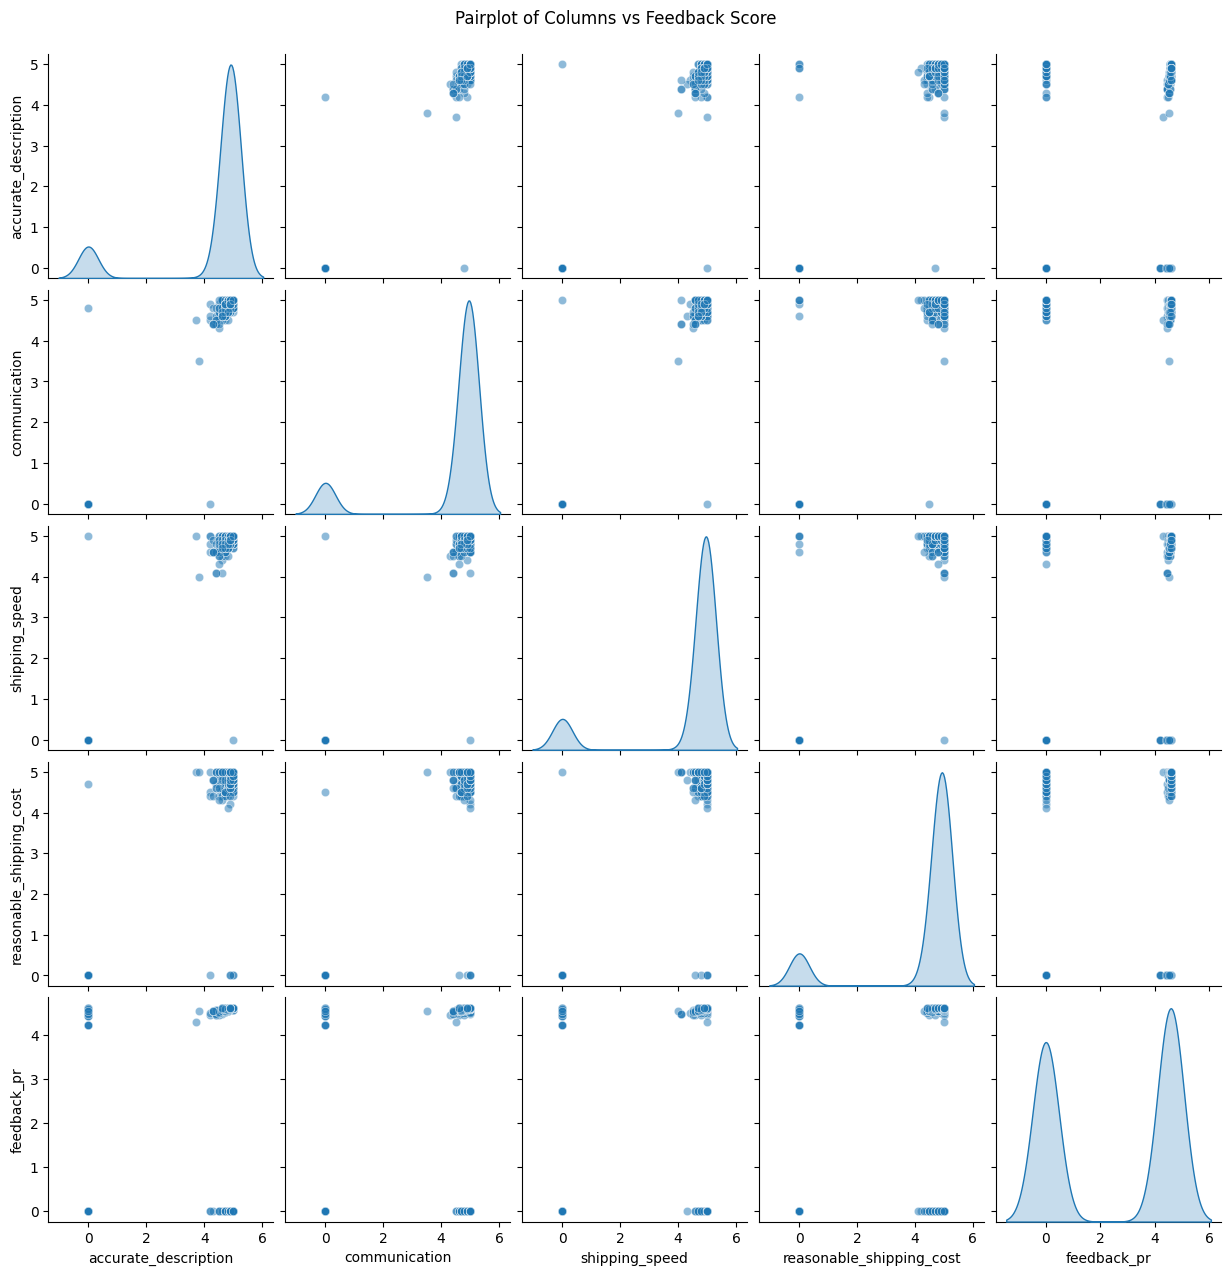

In [420]:
import seaborn as sns

# Select the columns of interest
columns = ['accurate_description', 'communication', 'shipping_speed', 'reasonable_shipping_cost', 'feedback_pr']

# Create a pairplot
sns.pairplot(df[columns], diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Columns vs Feedback Score', y=1.02)
plt.show()

-----
## Step - 4 pandas profiling 

In [239]:
# installing ydata-profiling library to generate report
!pip install ydata-profiling

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [240]:
from ydata_profiling import ProfileReport

# Generate the data profiling report 
report = ProfileReport(df, title='Ebay_Data')

# Save the report to an HTML file
report.to_file("pandas_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

-------
## Step 5 Encoding: One-Hot Encoding

In [409]:
# One-Hot Encoding on categorical columns
df_encoded = pd.get_dummies(df, columns=['seller_name'])

In [410]:
import re

# Cleans the comments in the 'comment' column by removing special characters and emojis. 
df['comment'] = df['comment'].apply(lambda x: re.sub(r'[^&\w\s,]', '', x) if pd.notna(x) else '')

# Display cleaned comments and no of columns
df.head()

,item_approx_price,accurate_description,seller_name,communication,shipping_speed,title,feedback_pr,item_primary_price,review_count,reasonable_shipping_cost,item_no,comment
0,0.00,4.9,pearlwholesale,4.9,4.9,Fashion Silver Zircon Christmas Xmas Elk Earri...,98.4,2.09,0,5.0,2.350810e+11,Perfect fit Arrived early than expected&Perfec...
3,190.66,4.9,dragonemad,5.0,5.0,Carly Universal Scanner BMW Diagnostic Best Ap...,0.0,139.85,26,4.9,1.238800e+11,Awesome I found things I didnt even know my ca...
6,15.90,4.7,Seven Star Solutions,4.8,4.8,"Aqua Red Perfume For Men, Long Lasting & Smoot...",0.0,11.66,0,5.0,3.746160e+11,"Good seller, otem as described and packed well..."
7,20.45,4.9,adalyn1973,5.0,5.0,"Alfred's Basic Piano Library lot of 3 Lesson, ...",0.0,15.00,0,4.9,3.855110e+11,Exactly as statedgreat vintage style Carolina ...
8,4.09,4.2,ray_6049,0.0,5.0,"PetSpy N10 Ultrasonic Dog Bark Deterrent, 2 Fr...",84.6,3.00,0,4.5,1.259120e+11,Rackety quack&Rackety quack&Missing critical c...


----
## Step 6 Identify Outliers with different technique

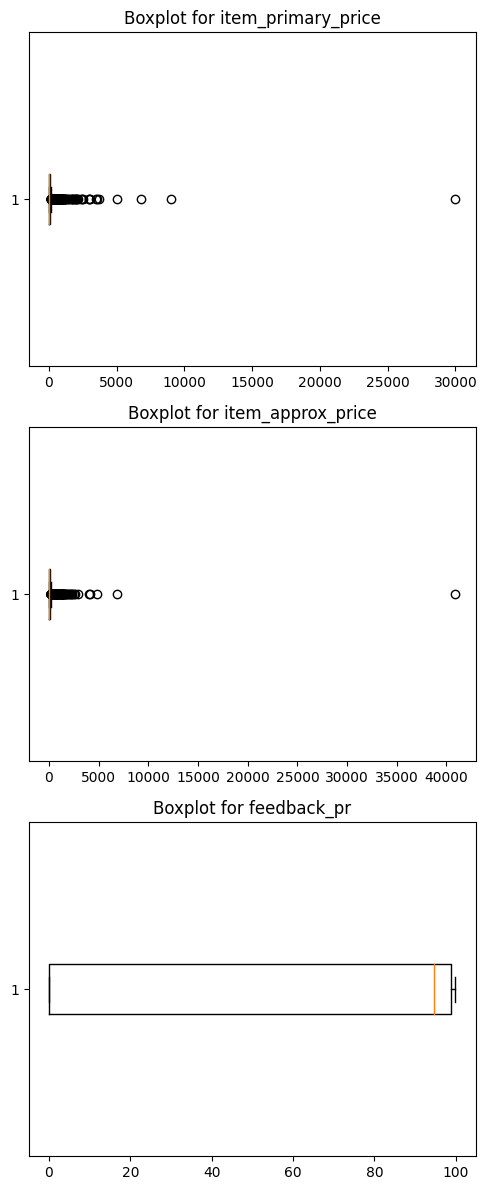

Outliers in item_primary_price: 94
Outliers in item_approx_price: 79
Outliers in feedback_pr: 0


In [411]:
import matplotlib.pyplot as plt

# Set up the plotting environment
fig, axes = plt.subplots(nrows=len(columns_to_check), figsize=(5, 4 * len(columns_to_check)))

# 1. Plot boxplots 
for i, column in enumerate(columns_to_check):
    ax = axes[i] if len(columns_to_check) > 1 else axes  # If there's only one column, axes is not a list
    ax.boxplot(df[column], vert=False) # Plot the boxplot horizontally
    ax.set_title(f'Boxplot for {column}') # Set title for boxplot

# Plot Boxplot
plt.tight_layout()
plt.show()

# 2. Identify outliers using IQR
for column in columns_to_check:
    q1 = df[column].quantile(0.10)
    q3 = df[column].quantile(0.90)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f'Outliers in {column}: {outliers[column].count()}') # Print number of outliers


-----
## Step 7 Handle outliers with 3 different techniques:
1. Quantile-based Flooring and Capping
2. Trimming
3. Log Transformation

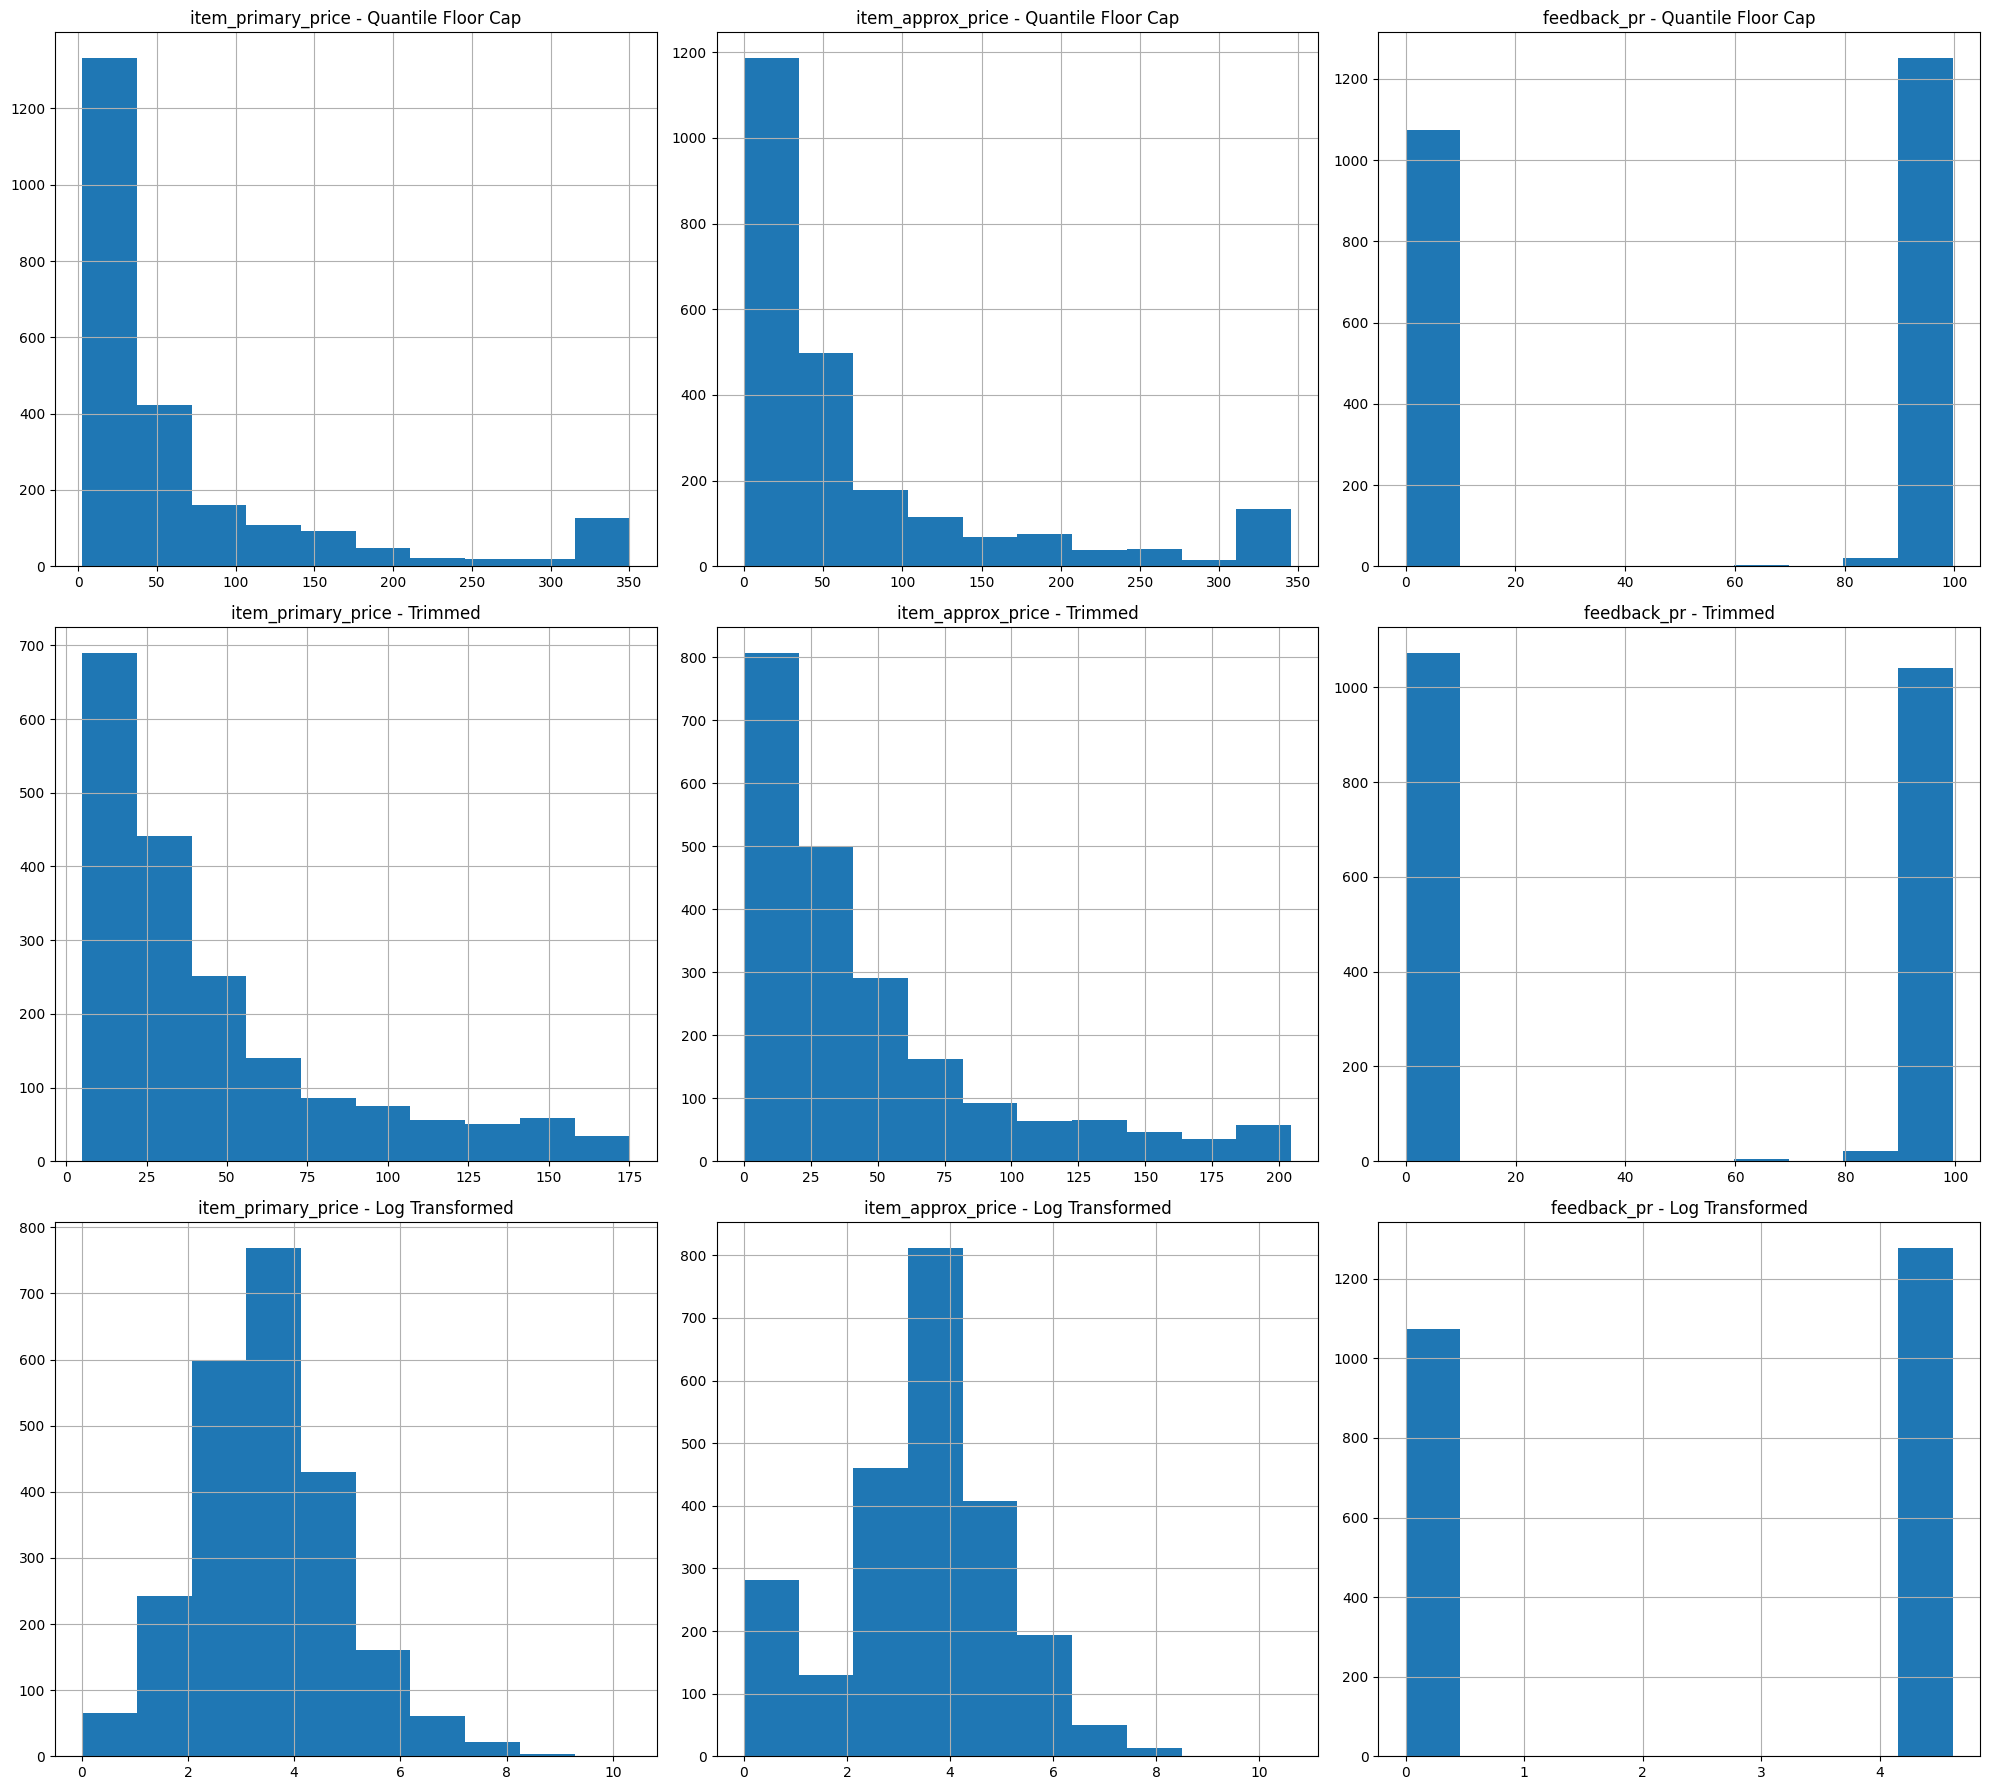

In [412]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Quantile-based Flooring and Capping function
quantile_floor_cap = lambda series, lower_percentile=0.05, upper_percentile=0.95: \
    series.clip(lower=series.quantile(lower_percentile), upper=series.quantile(upper_percentile))

# 2. Trimming function
trim_data = lambda series, trim_value=0.1: \
    series[(series >= series.quantile(trim_value)) & (series <= series.quantile(1 - trim_value))]

# 3. Log Transformation function
log_transform = lambda series: np.log1p(series)

# Store results in the new DataFrame
transformed_df = pd.DataFrame({f'{column}_quantile_floor_cap': quantile_floor_cap(df[column]),
                               f'{column}_trimmed': trim_data(df[column]),
                               f'{column}_log_transformed': log_transform(df[column])
                               } for column in columns_to_check)

# Plot the results
fig, axes = plt.subplots(nrows=3, ncols=len(columns_to_check), figsize=(20, 18))
for i, column in enumerate(columns_to_check):
    transformed_df[f'{column}_quantile_floor_cap'].hist(ax=axes[0, i])
    axes[0, i].set_title(f'{column} - Quantile Floor Cap')

    transformed_df[f'{column}_trimmed'].hist(ax=axes[1, i])
    axes[1, i].set_title(f'{column} - Trimmed')

    transformed_df[f'{column}_log_transformed'].hist(ax=axes[2, i])
    axes[2, i].set_title(f'{column} - Log Transformed')
    
plt.tight_layout()
plt.show()


In [413]:
for column in columns_to_check:
    df[column] = log_transform(df[column])
df.head()

,item_approx_price,accurate_description,seller_name,communication,shipping_speed,title,feedback_pr,item_primary_price,review_count,reasonable_shipping_cost,item_no,comment
0,0.000000,4.9,pearlwholesale,4.9,4.9,Fashion Silver Zircon Christmas Xmas Elk Earri...,4.599152,1.128171,0,5.0,2.350810e+11,Perfect fit Arrived early than expected&Perfec...
3,5.255723,4.9,dragonemad,5.0,5.0,Carly Universal Scanner BMW Diagnostic Best Ap...,0.000000,4.947695,26,4.9,1.238800e+11,Awesome I found things I didnt even know my ca...
6,2.827314,4.7,Seven Star Solutions,4.8,4.8,"Aqua Red Perfume For Men, Long Lasting & Smoot...",0.000000,2.538447,0,5.0,3.746160e+11,"Good seller, otem as described and packed well..."
7,3.065725,4.9,adalyn1973,5.0,5.0,"Alfred's Basic Piano Library lot of 3 Lesson, ...",0.000000,2.772589,0,4.9,3.855110e+11,Exactly as statedgreat vintage style Carolina ...
8,1.627278,4.2,ray_6049,0.0,5.0,"PetSpy N10 Ultrasonic Dog Bark Deterrent, 2 Fr...",4.449685,1.386294,0,4.5,1.259120e+11,Rackety quack&Rackety quack&Missing critical c...


----
## Step 8 Unsupervised Learning Methods:

#### 1. Gaussian Mixture Model (GMM)

In [414]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42) # Initialize GMM 
gmm.fit(df[feature_cols]) # Fit GMM to the data
labels = gmm.predict(df[feature_cols]) # predicted labels 
df['gmm_score'] = labels #score based on the predicted labels
selected_features = df.groupby('gmm_score')[feature_cols].mean().idxmax() # Sort the features based on the GMM scores

print("Selected Features:", selected_features) # Print selected features 


Selected Features: accurate_description        0
communication               0
shipping_speed              0
reasonable_shipping_cost    1
item_approx_price           0
feedback_pr                 1
dtype: int64


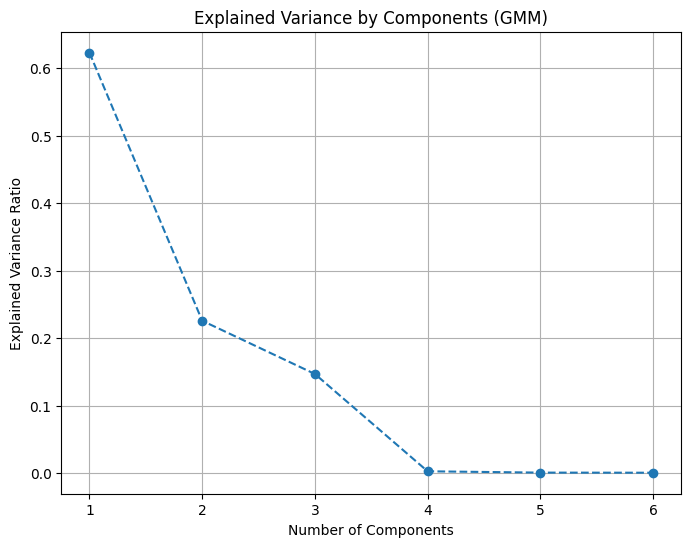

In [415]:
# Plot the explained variance ratios
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Components (GMM)')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

#### 2. K-Means Clustering 

In [416]:
from sklearn.preprocessing import StandardScaler

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[feature_cols])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


kmeans_cluster
2    1259
0     802
1     290
Name: count, dtype: int64


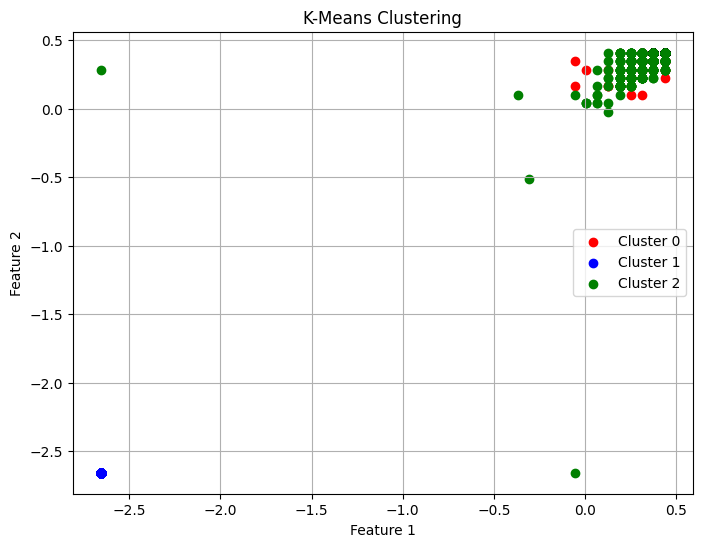

In [417]:
# Import libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(scaled_data)

print(df['kmeans_cluster'].value_counts()) # Results
kmeans_colors = ['red', 'blue', 'green'] # Assign colors for the clusters

# Plot the clusters
plt.figure(figsize=(8, 6))
for i in range(3):  # 3 clusters in K-Means Clustering
    plt.scatter(scaled_data[df.kmeans_cluster == i, 0], scaled_data[df.kmeans_cluster == i, 1], color=kmeans_colors[i], label=f'Cluster {i}')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


In [418]:
from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score
silhouette_score_kmeans = silhouette_score(scaled_data, df['kmeans_cluster'])
print(f"Silhouette Score for K-Means Clustering: {silhouette_score_kmeans}")


Silhouette Score for K-Means Clustering: 0.588629128757133


-----
## Step - 9 NLP techniques  

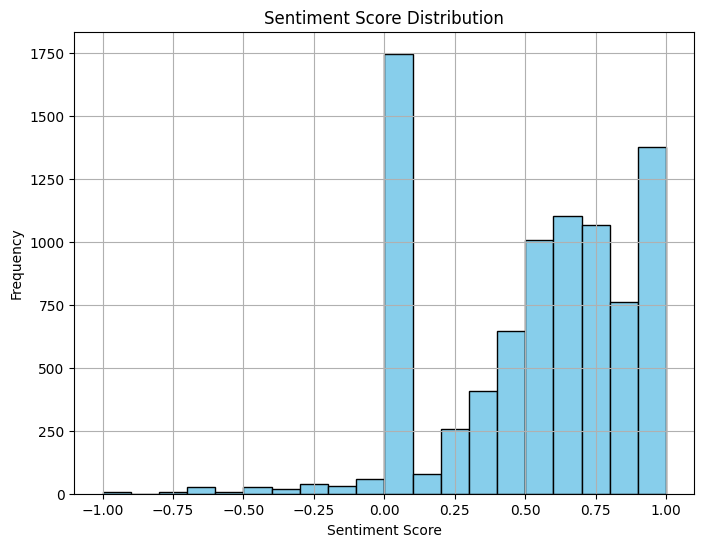

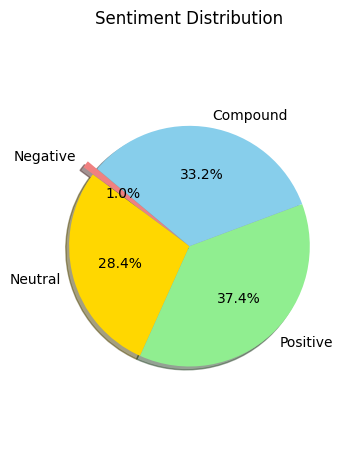

In [385]:
# Function to clean and preprocess text data
def text_cleaning(comment):
    tokens = word_tokenize(comment.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    lemmatized_tokens = [WordNetLemmatizer().lemmatize(token) for token in filtered_tokens]
    return ' '.join(lemmatized_tokens)

# Perform sentiment analysis using VADER
def sentiment_analysis(comments):
    analyzer = SentimentIntensityAnalyzer()
    return [analyzer.polarity_scores(text_cleaning(comment)) for comment in comments.split('&')]

# Calculate sentiment scores for each seller
df['sentiment_scores'] = df['comment'].apply(sentiment_analysis)

# Flatten sentiment scores and create a DataFrame
analyze_df = pd.DataFrame(df['sentiment_scores'].sum())

# Calculate overall sentiment score
analyze_df['score'] = analyze_df['pos'] - analyze_df['neg']

# Plot sentiment score distribution
plt.figure(figsize=(8, 6))
plt.hist(analyze_df['score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot sentiment distribution using pie chart
plt.subplot(1, 2, 2)
labels = ['Negative', 'Neutral', 'Positive', 'Compound']
sizes = [analyze_df['neg'].mean(), analyze_df['neu'].mean(), analyze_df['pos'].mean(), analyze_df['compound'].mean()]
colors = ['lightcoral', 'gold', 'lightgreen', 'skyblue']
explode = (0.1, 0, 0, 0)  # Explode the 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sentiment Distribution')

plt.tight_layout()
plt.show()

## Thank You!!!